## Food Inspection: Model Development

### Potential Features  

The initial plan is to consider these features.  The basic data cleaning was performed in the `feature_extraction.ipynb` notebook.  The data being pulled into this notebook is the combination of the City of Chicago Food Inspection and Business License dataset.  These datasets were combined to fill in some of the missing values and add a few features.  In the future, additional information will be added to further fill in missing data and to add features like cuisine type and number of Starbucks within a certain distance.   

**Identifying Columns:**    
1.  name  
1.  license number  

**Target values:**  
1.  result (pass/fail)  

**Features:** 
1.  business age (default start from 2010 inspection date)  
1.  number of chains / is_chain boolean 
1.  risk  
1.  ward / neighborhood
1.  license code  
1.  renew  
1.  conditional approved  
1.  business activity
1.  etc.....

In [5]:
# Import required libraries

# # Code formatter
# # !pip3 install nb_black
# %load_ext nb_black

# eda tools
import numpy as np
import pandas as pd

# visualization dependencies
import matplotlib.pyplot as plt  
import seaborn as sns  

# machine learning libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree  

# pipeline generation
from sklearn.pipeline import Pipeline  
from sklearn.compose import ColumnTransformer  
from sklearn.compose import make_column_selector

# hide jupyter lab warnings
import warnings
warnings.filterwarnings('ignore')

# expand the number of dataframe columns visible
pd.options.display.max_columns = 100

# make sound when this code executes: Audio(sound_file, autoplay=True)
from IPython.display import Audio
sound_file = './sound/chord.wav'

# display package informatin
# !conda install -c conda-forge session-info
import session_info
session_info.show()

### Read Dataset

In [49]:
# Read data
restaurant_df = pd.read_csv('./data/manipulated/combined_data.csv', parse_dates=['inspect_date', 'approx_start_date'])

# renamed first column - caused by including the index during the export from `feature_extraction.ipynb`.  This is the original index.  
restaurant_df.rename(columns={'Unnamed: 0':'original_index'}, inplace=True)
restaurant_df.head()

,original_index,inspect_id,aka_name_x,license_num,facility_type,risk,address_x,city,state,zipcode,inspect_date,inspect_type,results,violations,lat,lon,violations_list,violation_count,violation_number,vl_must_comply_list,vl_must_comply_count,vl_instructed_comply_list,vl_instructed_comply_count,vl_not_cited_list,vl_citation_count,year,month,aka_name_y,license_id,address_y,ward,precint,police_district,license_code,license_description,bus_activity_id,bus_activity,application_type,conditional_approval,approx_start_date,year_min,year_max,bus_age,license_alias,number_of_chains,week,inspections_per_year,type_of_restaurant
0,3,2579789,SENOR PAN CAFE,2659113.0,Restaurant,Risk 1 (High),4612 W FULLERTON AVE,CHICAGO,IL,60639.0,2023-08-09,Canvass Re-Inspection,Pass,-99. No violations reported,41.924402,-87.742318,['-99. No violations reported'],1,['99'],[False],0,[False],0,[False],1,2023,8,SENOR PAN CAFE,2899694.0,4612 W FULLERTON AVE 1,31.0,29.0,25.0,1006.0,Retail Food Establishment,735,Preparation of Food and Dining on Premise With...,RENEW,N,2023-05-16,2019.0,2023.0,4.0,14065,5,32,12,2-5 Sites
1,4,2579779,TAQUERIA CD HIDALGO,2078867.0,Restaurant,Risk 1 (High),7104 N CLARK ST,CHICAGO,IL,60626.0,2023-08-08,Canvass,Pass,-99. No violations reported,42.011581,-87.674614,['-99. No violations reported'],1,['99'],[False],0,[False],0,[False],1,2023,8,TAQUERIA CD HIDALGO,2884398.0,7104 N CLARK ST 1ST,49.0,3.0,24.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,RENEW,N,2023-02-16,2011.0,2023.0,12.0,15894,1,32,24,Single Site
2,7,2579723,BAR COCINA,2334704.0,Restaurant,Risk 1 (High),2901 N SHEFFIELD AVE,CHICAGO,IL,60657.0,2023-08-08,Canvass Re-Inspection,Pass,-99. No violations reported,41.934501,-87.653775,['-99. No violations reported'],1,['99'],[False],0,[False],0,[False],1,2023,8,BAR COCINA,2898722.0,2901 N SHEFFIELD AVE 1,44.0,29.0,19.0,1006.0,Retail Food Establishment,735,Preparation of Food and Dining on Premise With...,RENEW,N,2023-05-16,2015.0,2023.0,8.0,1121,1,32,17,Single Site
3,8,2579643,Itoko / GG'S Chicken Shop / Little Goat Diner,2872999.0,Restaurant,Risk 1 (High),3323-3325 N SOUTHPORT AVE,CHICAGO,IL,60657.0,2023-08-07,Complaint Re-Inspection,Pass,-99. No violations reported,41.942334,-87.663739,['-99. No violations reported'],1,['99'],[False],0,[False],0,[False],1,2023,8,Itoko / GG's Chicken Shop / Little Goat Diner,2872999.0,3323-3325 N SOUTHPORT AVE LL-2,44.0,NaN,NaN,1006.0,Retail Food Establishment,735,Preparation of Food and Dining on Premise With...,ISSUE,Y,2023-02-21,2023.0,2023.0,0.0,7640,1,32,6,Single Site
4,10,2579561,JIN JU,27137.0,Restaurant,Risk 1 (High),5203 N CLARK ST,CHICAGO,IL,60640.0,2023-08-04,Canvass,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.976301,-87.668276,['10. ADEQUATE HANDWASHING SINKS PROPERLY SUPP...,4,"['10', '47', '55', '58']","[False, False, False, False]",0,"[False, False, False, False]",0,"[False, False, False, False]",4,2023,8,JIN JU,2907977.0,5203 N CLARK ST 1ST,48.0,10.0,20.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,RENEW,N,2023-07-16,2001.0,2023.0,22.0,8059,1,31,19,Single Site


### Prep 

In [50]:
# simplify column headers (after one-hot-encoding these categories become header titles)
temp_dict = {'Risk 1 (High)':'high', 'Risk 2 (Medium)':'medium', 'Risk 3 (Low)':'low',np.nan: np.nan}
restaurant_df['risk'] = restaurant_df['risk'].apply(lambda x: temp_dict[x])

In [51]:
# limit dataset records
df = restaurant_df[restaurant_df['inspect_date'] > '2018-01-01']

In [52]:
# define target and feature columns
# maybe add violation id number to the model
target = df['results']

columns = ['risk', 'inspect_type', 'violation_count',
       'vl_must_comply_count',
       'vl_instructed_comply_count',
       'vl_citation_count', 'ward', 
       'license_code', 'bus_activity_id',
       'application_type', 'conditional_approval',
       'bus_age', 'number_of_chains']
features = df[columns]

In [53]:
print('Target Shape: ', target.shape)
print('Feature Shape: ', features.shape )

Target Shape:  (53353,)
Feature Shape:  (53353, 13)


In [54]:
# inspect data types
features.dtypes

risk                           object
inspect_type                   object
violation_count                 int64
vl_must_comply_count            int64
vl_instructed_comply_count      int64
vl_citation_count               int64
ward                          float64
license_code                  float64
bus_activity_id                object
application_type               object
conditional_approval           object
bus_age                       float64
number_of_chains                int64
dtype: object

In [55]:
# Convert objects to category
features[features.select_dtypes(['object']).columns] = features.select_dtypes(['object']).apply(lambda x: x.astype('category'))

# Convert non-objects to category
features['ward'] = features['ward'].astype('category')
features['license_code'] = features['license_code'].astype('category')

# Convert float to integer
features['bus_age'] = features['bus_age'].astype('int')

In [56]:
# check data types after transformations
features.dtypes

risk                          category
inspect_type                  category
violation_count                  int64
vl_must_comply_count             int64
vl_instructed_comply_count       int64
vl_citation_count                int64
ward                          category
license_code                  category
bus_activity_id               category
application_type              category
conditional_approval          category
bus_age                          int32
number_of_chains                 int64
dtype: object

## Limits

In [73]:
# Some imbalance exists.  Since the two classes are about 20% which is 1/3 of the majority class, it will probably be influenced by the inbalance.    
# If the majority class was only 2x the size of the smallest minority class then it would be considered marginally unbalanced.  
restaurant_df['results'].value_counts(normalize=True)

Pass                  0.587696
Fail                  0.214410
Pass w/ Conditions    0.197893
Name: results, dtype: float64

## Preprocess 

In [14]:
# numerica columns selected
numeric_features = features.select_dtypes(['int'])

# categorical selection and encoded
categorical_features = features.select_dtypes(['category'])
encoder = OneHotEncoder(categories='auto')
encoder.fit(categorical_features)  
transformed_features = encoder.transform(categorical_features)  

# adding column names to dataframe and using later for importance scores
col = categorical_features.columns
column_name = encoder.get_feature_names_out(col)
transformed_features_df = pd.DataFrame.sparse.from_spmatrix(transformed_features, columns=column_name)
print('Categorical feature shape:  ', transformed_features_df.shape)

Categorical feature shape:   (53353, 274)


In [11]:
# preview dataframe of numeric and categorical data
# transformed_features_df.head()

In [15]:
# create features for model

# at first when concatenating, the number of rows increased.  The reason is that the indexes did not match due to changes that occurred during transformations
# solution was to reset the index for each dataframe
encoded_features = pd.concat([numeric_features.reset_index(drop=True), transformed_features_df.reset_index(drop=True)], axis=1)
# converting headers to strings to prevent problems in later steps
encoded_features.columns = encoded_features.columns.astype(str)
# check full feature set shape
print('Encoded feature shape:  ', encoded_features.shape)

Encoded feature shape:   (53353, 280)


In [57]:
# create labels for model
label_encoder = LabelEncoder()
label_encoder.fit(target)
encoded_target = label_encoder.transform(target)
target_classes = label_encoder.classes_
print(target_classes)

['Fail' 'Pass' 'Pass w/ Conditions']


In [82]:
# create model - split data, select model, fit model and output accuracy as generic outcome
X_train, X_test, y_train, y_test = train_test_split(encoded_features, encoded_target, train_size=0.7, random_state=42)
unique_labels, counts = np.unique(y_train, return_counts=True)
percentages = dict(zip(unique_labels, counts*100/len(y_train)))

for i in percentages.items():
    print(i)

# this shows that there is only moderate imbalance in the training data.

(0, 22.507831954373845)
(1, 44.88446193804054)
(2, 32.607706107585614)


In [ ]:
# create basic model
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=10,
                                       n_estimators=100, oob_score=True)

# train model
classifier_rf.fit(X_train, y_train)

# accuracy score is not too informative
# classification report can be more informative; will test these during testing phase
# not sure if AUC/ROC curve can be made for multi-class target - will need to investigate.  
classifier_rf.oob_score_


### Optimize model

In [18]:
# select model and parameters
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2,3,5,10,20,30,40],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

# create parameter search and cross validation  
# probably should use something besides accuracy for the scoring metric
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 252 candidates, totalling 1008 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20, 30, 40],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [19]:
# find model performance information
rf_best = grid_search.best_estimator_
print('Best Accuracy Score:  ', grid_search.best_score_)
print('Model Parameters:  ', rf_best)

Best Accuracy Score:   0.6387661443874555
Model Parameters:   RandomForestClassifier(max_depth=40, min_samples_leaf=5, n_jobs=-1,
                       random_state=42)


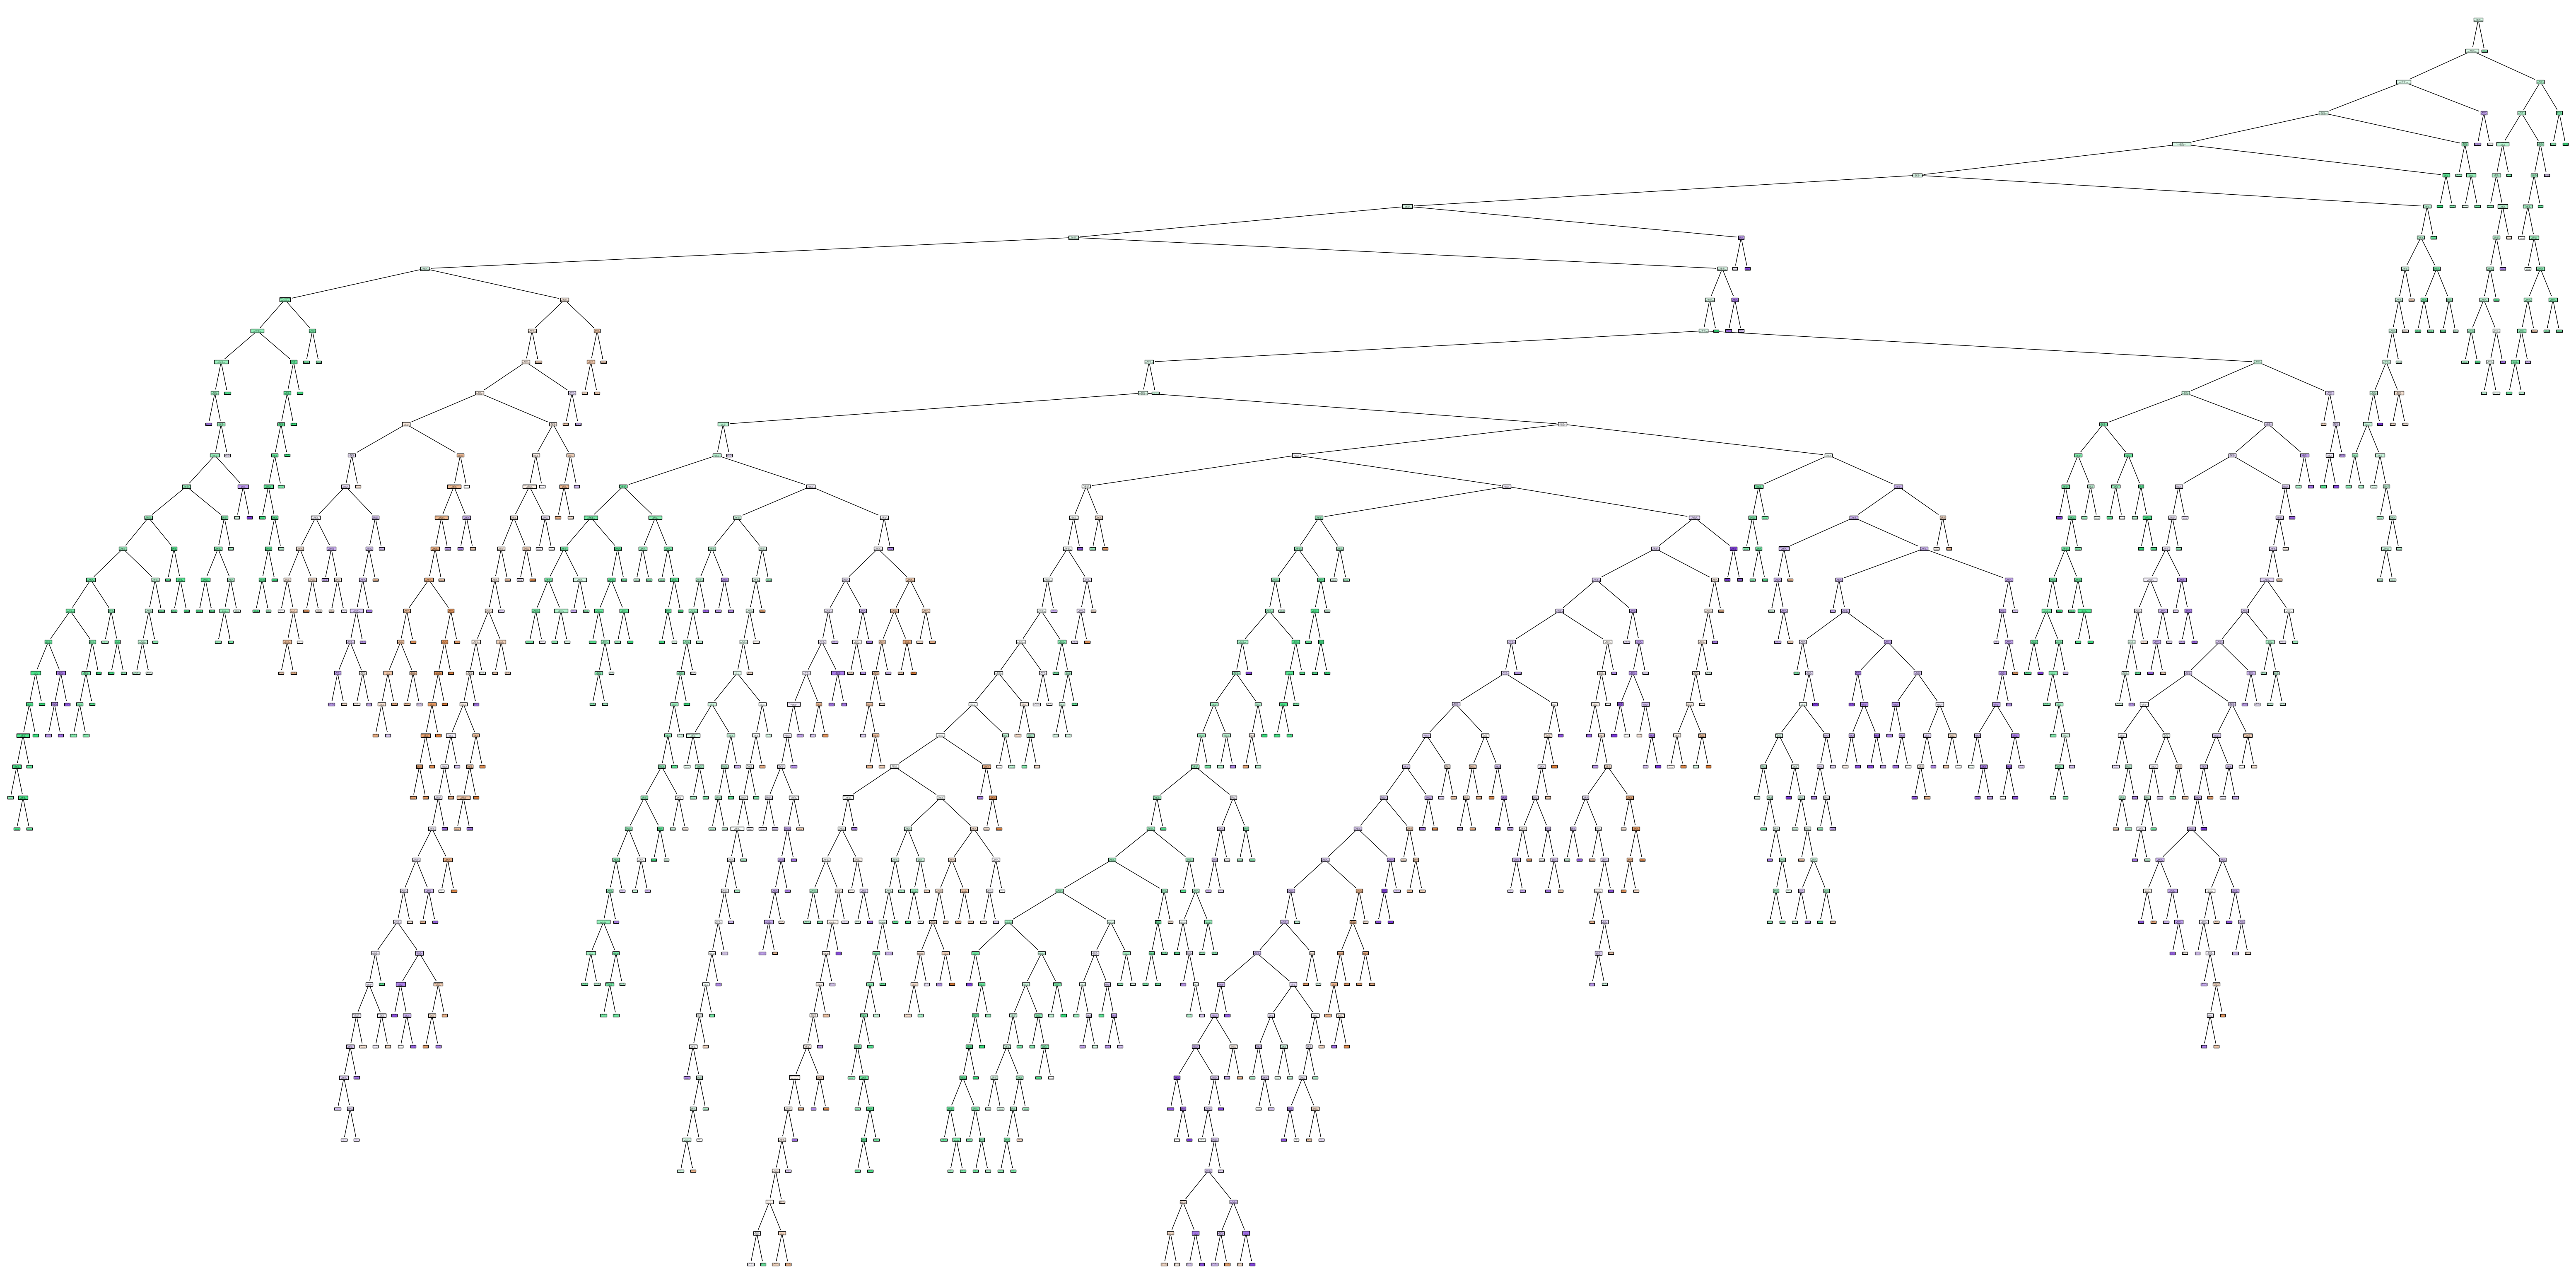

In [20]:
# visualize tree - select one tree but many to choose from
plt.figure(figsize=(80,40))
plot_tree(rf_best.estimators_[1], feature_names = encoded_features.columns,class_names=['Passed', "Failed","Other"],filled=True);

In [21]:
# create dataframe to show most important features
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_best.feature_importances_
})
temp = imp_df.sort_values(by="Imp", ascending=False)
temp.head(50)

,Varname,Imp
0,violation_count,0.433465
3,vl_citation_count,0.305065
10,inspect_type_Canvass Re-Inspection,0.023612
4,bus_age,0.023392
11,inspect_type_Complaint,0.017753
5,number_of_chains,0.016612
9,inspect_type_Canvass,0.015719
12,inspect_type_Complaint Re-Inspection,0.013921
14,inspect_type_License,0.008615
62,ward_42.0,0.006446


**Analysis**  
Ward 41, Ward 42, Ward 13, and Ward 34 seem to be different than the other wards.  I think some of these are close to the airports - O'Hare and Midway.  The location should not have an influence on the inspection results unless there is a latent variable effect or there is a bias.  

Violation count and citation count are related but citation count means some of the violations were more severe.  It makes complete sense that these features would be important.  

Other important features include inspection type, business age, and number of chains.  The other features don't seem important.  

I should add in violation code to the model after removing the unimportant features.  There should be some relation among several of the features.  

### Test Model

In [47]:
# View training results  
from sklearn.metrics import classification_report, confusion_matrix  

best_model = rf_best.fit(X_train, y_train)
y_train_predicted = best_model.predict(X_train)

print(classification_report(y_train, y_train_predicted, target_names=target_classes))  
print(confusion_matrix(y_train, y_train_predicted))

                    precision    recall  f1-score   support

              Fail       0.65      0.42      0.51      8406
              Pass       0.72      0.86      0.79     16763
Pass w/ Conditions       0.60      0.59      0.60     12178

          accuracy                           0.67     37347
         macro avg       0.66      0.62      0.63     37347
      weighted avg       0.67      0.67      0.66     37347

[[ 3509  2011  2886]
 [  481 14420  1862]
 [ 1450  3537  7191]]


In [48]:
# View testing results  
y_test_predicted = best_model.predict(X_test)

print(classification_report(y_test, y_test_predicted, target_names=target_classes))  
print(confusion_matrix(y_test, y_test_predicted))


                    precision    recall  f1-score   support

              Fail       0.59      0.38      0.46      3663
              Pass       0.71      0.85      0.77      7141
Pass w/ Conditions       0.56      0.54      0.55      5202

          accuracy                           0.64     16006
         macro avg       0.62      0.59      0.60     16006
      weighted avg       0.63      0.64      0.63     16006

[[1398  912 1353]
 [ 205 6063  873]
 [ 763 1616 2823]]


In [24]:
import pickle

# save model  
with open('model.pkl','wb') as f:
    pickle.dump(rf_best,f)


### Simple Pipeline method  

Note:  I would like to include the target into the pipeline.  This will require using an extension of scikit-learn or creating some custom code to achieve this effect.  

In [65]:
# identify numeric columns and process
# standard scaler is not really needed in this case
numeric_features = make_column_selector(dtype_exclude='category')
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])

# identify categorical columns and process
categorical_features = make_column_selector(dtype_include='category')
categorical_transformer = OneHotEncoder(categories='auto', handle_unknown='ignore') 


# add number and category transformations and specify columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        ])

In [66]:
# create pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100))
                    ])

In [67]:
# split data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_target , train_size=0.7, random_state=42)

In [68]:
# most of the time a CV method would be used in a pipeline
# train pipeline on data
clf.fit(X_train, y_train)

# show score - need to evaluation with classification report  
print(clf.score(X_test, y_test))

0.5410471073347495


In [69]:
# show evaluation of training data  
# note1:  this evaluation is not very useful except when comparing the differences to the test data set
# note2:  large changes in the model fit (going down between the train and test) indicate that there is overfitting occuring.  
# note3:  underfitting is observed by seeing large errors in the model.  
from sklearn.metrics import classification_report

# Get the predictions and labels
predictions = clf.predict(X_train)
labels = y_train

# Get the classification report
report = classification_report(labels, predictions, target_names=target_classes)
print(report)

# for fails, it has an 80% identifying correctly but only identifies a small number of cases.


                    precision    recall  f1-score   support

              Fail       0.79      0.01      0.02      8406
              Pass       0.63      0.82      0.71     16763
Pass w/ Conditions       0.42      0.54      0.47     12178

          accuracy                           0.54     37347
         macro avg       0.61      0.45      0.40     37347
      weighted avg       0.60      0.54      0.48     37347



In [71]:
# show evaluation of testing data  
# Get the predictions and labels
predictions = clf.predict(X_test)
labels = y_test

# Get the classification report
report = classification_report(labels, predictions, target_names=target_classes)
print(report)

                    precision    recall  f1-score   support

              Fail       0.71      0.01      0.02      3663
              Pass       0.63      0.82      0.71      7141
Pass w/ Conditions       0.42      0.54      0.47      5202

          accuracy                           0.54     16006
         macro avg       0.59      0.45      0.40     16006
      weighted avg       0.58      0.54      0.47     16006



In [41]:
# create ROC/AUC evaluation  
from sklearn.metrics import roc_auc_score

# Predict the labels of the test data
y_pred = clf.predict(X_test)

# Calculate the ROC AUC
pred_prob = clf.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, pred_prob, multi_class='ovr')
print(roc_auc)


0.7498876839133102


In [ ]:
import pickle

# save model  
with open('model.pkl','wb') as f:
    pickle.dump(clf,f)

# # load model
# with open('model.pkl', 'rb') as f:
#     clf2 = pickle.load(f)

### Analysis  
- compare classification report
- evaluate feature importance  

### Future Steps  
- What features to remove
- What features to add to the model  
- Change CV eval metric from accuracy to precision/recall
- Create new notebook for further evaluation - classification reports, ROC/AUC curves  
- Maybe add food type (geo_feature notebook) and menu information to model  
